# Estrutura da Base de Dados

Nome do arquivo: Base_M43_Pratique_CREDIT_CARD_FRAUD.csv

Tamanho do arquivo: aproximadamente 143,8 MB

Número de linhas (registros): 284.807

Número de colunas (atributos): 31
# Descrição das Colunas

O dataset segue um padrão típico de bases de detecção de fraude em cartões de crédito:

Time → tempo decorrido (em segundos) desde a primeira transação registrada.

V1 a V28 → variáveis resultantes de uma transformação de PCA (análise de componentes principais) para proteger dados confidenciais dos clientes.

Amount → valor da transação.

Class → variável alvo (0 = transação legítima, 1 = fraude).


In [ ]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Carregar data frame
df = pd.read_csv("/content/Base_M43_Pratique_CREDIT_CARD_FRAUD.csv")
print(df.shape)
print(df['Class'].value_counts())

(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
# Visualizando dados
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Análise exploratória de dados (aed)

Realizar uma análise aprofundada dos dados para entender a distribuição das classes, identificar possíveis outliers e visualizar as relações entre as variáveis, com foco no problema de detecção de fraude.


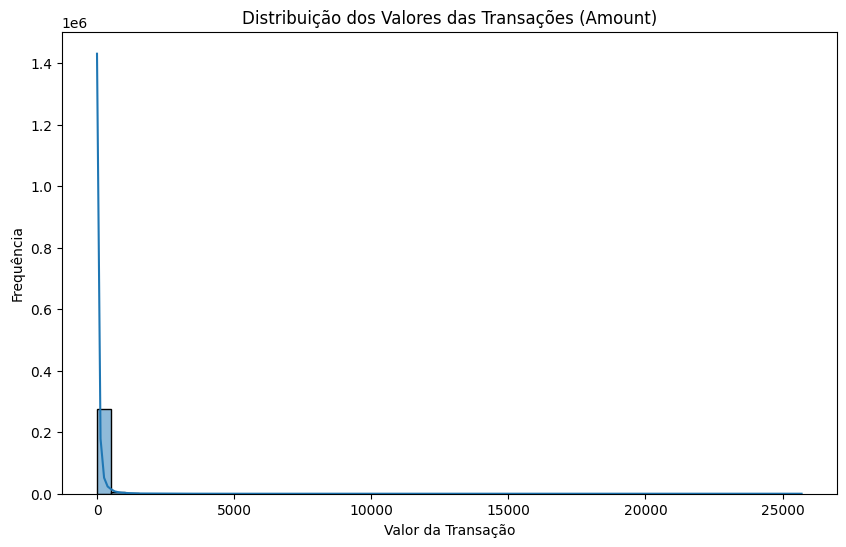

In [ ]:
# 1. Histograma da coluna 'Amount'
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribuição dos Valores das Transações (Amount)')
plt.xlabel('Valor da Transação')
plt.ylabel('Frequência')
plt.show()

Distribuição dos Valores das Transações (Amount) - Histograma:

 Este histograma mostra que a grande maioria das transações tem valores baixos, concentrando-se perto de zero. A distribuição é altamente assimétrica, com uma longa cauda à direita, indicando a presença de algumas transações de valores muito altos (outliers). A maior frequência de transações ocorre em valores abaixo de 100.

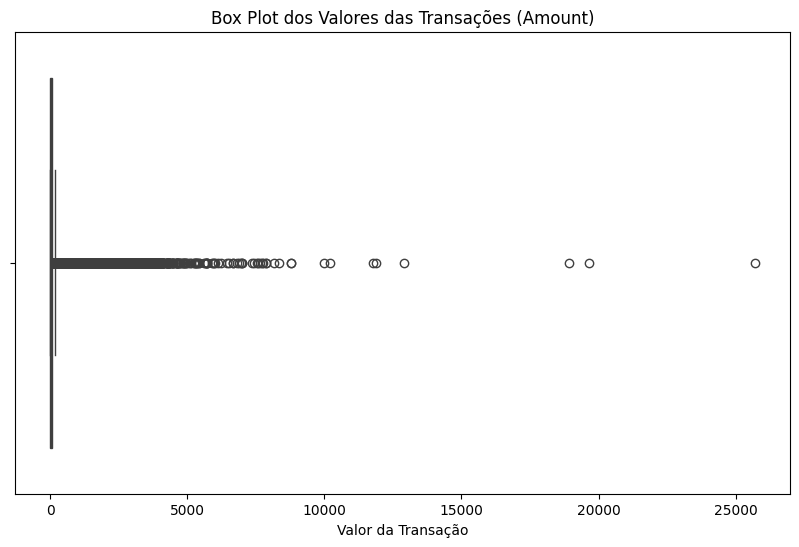

In [ ]:
# 2. Box plot da coluna 'Amount'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Amount'])
plt.title('Box Plot dos Valores das Transações (Amount)')
plt.xlabel('Valor da Transação')
plt.show()

Box Plot dos Valores das Transações (Amount):

O box plot reforça a observação do histograma sobre a assimetria e a presença de outliers. A caixa principal (que representa a maioria dos dados) é muito estreita e próxima de zero, enquanto há muitos pontos individuais (outliers) espalhados ao longo do eixo horizontal, representando transações com valores significativamente mais altos do que a maioria.

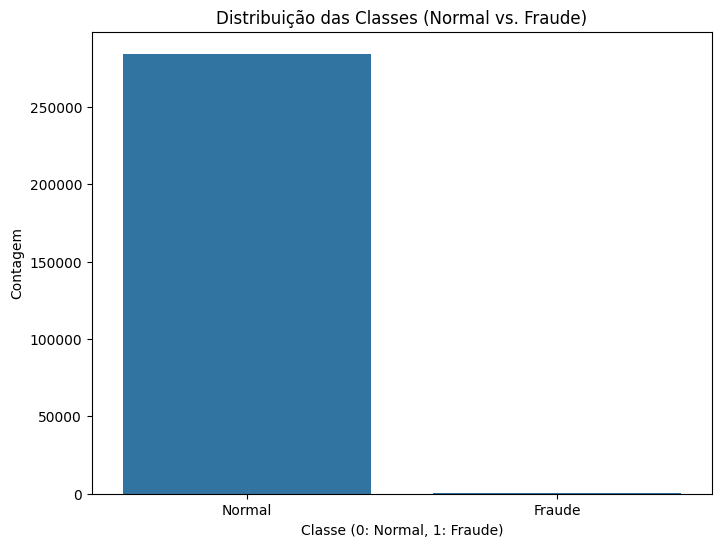

In [ ]:
# 3. Gráfico de contagem para a coluna 'Class'
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Class'])
plt.title('Distribuição das Classes (Normal vs. Fraude)')
plt.xlabel('Classe (0: Normal, 1: Fraude)')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['Normal', 'Fraude'])
plt.show()

Gráfico de Contagem para a Coluna 'Class':

Este gráfico de barras ilustra claramente o severo desbalanceamento do dataset. A barra para a classe 'Normal' (0) é esmagadoramente maior do que a barra para a classe 'Fraude' (1), demonstrando que a grande maioria das transações no dataset são normais, com um número muito pequeno de transações fraudulentas.

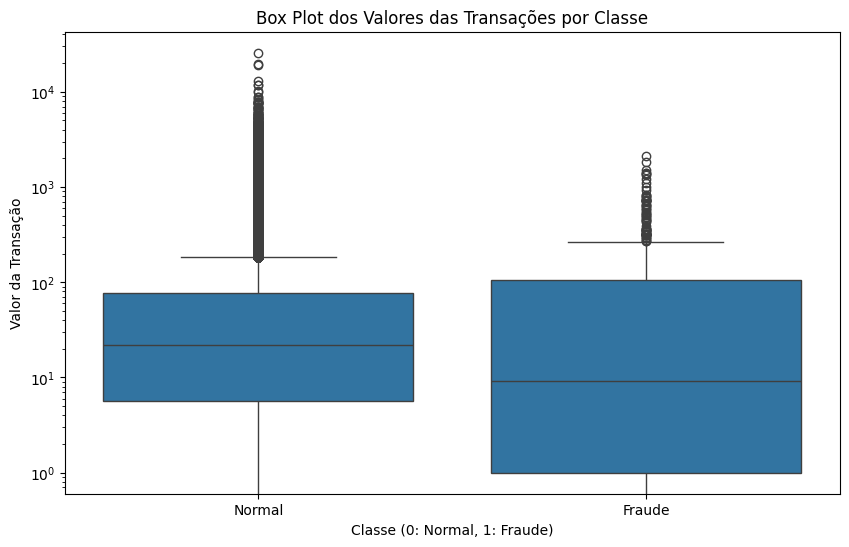

In [ ]:
# 4. Box plot da coluna 'Amount' separado por classe ('Class')
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Box Plot dos Valores das Transações por Classe')
plt.xlabel('Classe (0: Normal, 1: Fraude)')
plt.ylabel('Valor da Transação')
plt.xticks([0, 1], ['Normal', 'Fraude'])
plt.yscale('log') # Usar escala logarítmica para melhor visualização
plt.show()

Box Plot dos Valores das Transações por Classe:

Este box plot compara a distribuição dos valores das transações ('Amount') entre as classes 'Normal' (0) e 'Fraude' (1), utilizando uma escala logarítmica no eixo y para melhor visualização devido à assimetria. Embora ambas as classes apresentem outliers de alto valor, a distribuição dos valores parece ser ligeiramente diferente entre transações normais e fraudulentas, o que pode ser uma feature importante para o modelo.

## Pré-processamento dos dados

Realizar as etapas de pré-processamento necessárias, como tratamento de valores ausentes, padronização/escalonamento das features numéricas e codificação de variáveis categóricas. Dividir os dados em conjuntos de treino e teste.


In [ ]:
# 1. Tratar com os valores ausentes
print("Antes de remover linhas com valores nulos:", df.shape)
df.dropna(inplace=True)
print("Após remover linhas com valores nulos:", df.shape)

# 2. Separar features (X) da variável alvo (y)
X = df.drop('Class', axis=1)
y = df['Class']

# 3. Removendo duplicatas
print("Antes de remover duplicatas:", df.shape)
df = df.drop_duplicates()
print("Após remover duplicatas:", df.shape)

# 4. Tratando outiliers
df['Amount_log'] = np.log1p(df['Amount'])

# 5. Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTamanho do conjunto de treino (X_train, y_train):", X_train.shape, y_train.shape)
print("Tamanho do conjunto de teste (X_test, y_test):", X_test.shape, y_test.shape)
print("\nDistribuição das classes no treino:\n", y_train.value_counts(normalize=True))
print("Distribuição das classes no teste:\n", y_test.value_counts(normalize=True))

# 6. Identificar colunas numéricas para escalonamento
# Excluir 'Class' (variável alvo) e 'Amount_log' (já é uma transformação de Amount)
# As colunas V's já parecem estar transformadas, então vamos escalar 'Time' e 'Amount'
numeric_features = ['Time', 'Amount']

# 7. Aplicar padronização (StandardScaler) às features numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)],
    remainder='passthrough' # Manter as outras colunas (V's) inalteradas
)

# Ajustar o pré-processador nos dados de treino e transformar ambos treino e teste
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Converter os resultados de volta para DataFrame para manter os nomes das colunas
# Obter os nomes das colunas após a transformação
# As colunas numéricas escalonadas vêm primeiro, seguidas pelas colunas restantes
scaled_columns_names = numeric_features + [col for col in X.columns if col not in numeric_features]

X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaled_columns_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=scaled_columns_names, index=X_test.index)


# 6. Armazenar os dados pré-processados e divididos, ja feito acima
# X_train_scaled, X_test_scaled, y_train, y_test estão prontos para uso

print("\nPrimeiras linhas do X_train_scaled após pré-processamento:")
display(X_train_scaled.head())
print("\nPrimeiras linhas do X_test_scaled após pré-processamento:")
display(X_test_scaled.head())

Antes de remover linhas com valores nulos: (284807, 31)
Após remover linhas com valores nulos: (284807, 31)
Antes de remover duplicatas: (284807, 31)
Após remover duplicatas: (283726, 31)

Tamanho do conjunto de treino (X_train, y_train): (227845, 30) (227845,)
Tamanho do conjunto de teste (X_test, y_test): (56962, 30) (56962,)

Distribuição das classes no treino:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Distribuição das classes no teste:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Primeiras linhas do X_train_scaled após pré-processamento:


,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
265518,1.411588,-0.322494,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,...,-0.451365,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248
180305,0.623141,-0.339764,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,...,-0.274411,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002
42664,-1.130680,0.346693,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,...,0.004631,1.280856,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340
198723,0.794699,-0.327360,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,...,0.257424,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005
82325,-0.748102,-0.008281,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,...,-0.082746,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194



Primeiras linhas do X_test_scaled após pré-processamento:


,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
263020,1.387182,-0.259954,-0.674466,1.408105,-1.110622,-1.328366,1.388996,-1.308439,1.885879,-0.614233,...,-0.162648,0.394322,0.080084,0.810034,-0.224327,0.707899,-0.135837,0.045102,0.533837,0.291319
11378,-1.580138,-0.304426,-2.829816,-2.765149,2.537793,-1.074580,2.842559,-2.153536,-1.795519,-0.250020,...,0.397057,-0.515765,-0.295555,0.109305,-0.813272,0.042996,-0.027660,-0.910247,0.110802,-0.511938
147283,-0.138120,-0.048286,-3.576495,2.318422,1.306985,3.263665,1.127818,2.865246,1.444125,-0.718922,...,0.098738,2.034786,-1.060151,0.016867,-0.132058,-1.483996,-0.296011,0.062823,0.552411,0.509764
219439,0.986536,-0.347741,2.060386,-0.015382,-1.082544,0.386019,-0.024331,-1.074935,0.207792,-0.338140,...,0.097040,-0.192024,-0.281684,-0.639426,0.331818,-0.067584,-0.283675,0.203529,-0.063621,-0.060077
36939,-1.182272,-0.345707,1.209965,1.384303,-1.343531,1.763636,0.662351,-2.113384,0.854039,-0.475963,...,-1.045263,0.009083,-0.164015,-0.328294,-0.154631,0.619449,0.818998,-0.330525,0.046884,0.104527


## Treinar e otimizar o modelo de árvore de decisão

Treinar um modelo de Árvore de Decisão no conjunto de treino e usar validação cruzada e ajuste de hiperparâmetros (Grid Search ou Random Search) para encontrar a melhor configuração.


In [ ]:
# 1. Importar DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# 2. Importar GridSearchCV
from sklearn.model_selection import GridSearchCV

# 3. Definir um dicionário param_grid_dt com os hiperparâmetros a serem testados
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 4. Montar um objeto DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# 5. Montar um objeto GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt_model,
                              param_grid=param_grid_dt,
                              cv=5, # 5-fold cross-validation
                              scoring='recall', # Use recall as the scoring metric due to class imbalance
                              n_jobs=-1) # Use all available processors

# 6. Ajustar o GridSearchCV aos dados de treino escalonados
grid_search_dt.fit(X_train_scaled, y_train)

# 7. Armazenar o melhor modelo encontrado pelo GridSearchCV
best_dt_model = grid_search_dt.best_estimator_

# 8. Imprimir os melhores hiperparâmetros e a melhor pontuação
print("Melhores hiperparâmetros para a Árvore de Decisão:")
print(grid_search_dt.best_params_)
print("\nMelhor pontuação de validação cruzada (Recall):")
print(grid_search_dt.best_score_)

Melhores hiperparâmetros para a Árvore de Decisão:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Melhor pontuação de validação cruzada (Recall):
0.8856215514443362


In [ ]:
# Imprimir os melhores hiperparâmetros e a melhor pontuação corrigindo o erro anterior
print("Melhores hiperparâmetros para a Árvore de Decisão:")
print(grid_search_dt.best_params_)
print("\nMelhor pontuação de validação cruzada (Recall):")
print(grid_search_dt.best_score_)

Melhores hiperparâmetros para a Árvore de Decisão:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Melhor pontuação de validação cruzada (Recall):
0.8856215514443362


## Avaliar o modelo de árvore de decisão

Avaliar o desempenho do melhor modelo de Árvore de Decisão no conjunto de teste utilizando métricas apropriadas para dados desbalanceados (como Precisão, Recall, F1-Score e Área sob a Curva ROC).


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Obter o melhor modelo de Árvore de Decisão
best_dt_model = grid_search_dt.best_estimator_

# 2. Fazer previsões no conjunto de teste
y_pred_dt = best_dt_model.predict(X_test_scaled)

# 3. Fazer previsões das probabilidades no conjunto de teste
y_pred_proba_dt = best_dt_model.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a classe positiva (classe 1)

# 4. Calcular a Acurácia
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# 5. Calcular a Precisão, Recall e F1-Score
# O classification_report retorna Precisão, Recall, F1-Score e Suporte para cada classe
classification_report_dt = classification_report(y_test, y_pred_dt, target_names=['Normal (0)', 'Fraude (1)'])

# 6. Calcular a Área sob a Curva ROC (AUC-ROC)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

# 7. Imprimir todas as métricas calculadas
print("Avaliação do Melhor Modelo de Árvore de Decisão no Conjunto de Teste:")
print(f"Acurácia: {accuracy_dt:.4f}")
print("\nRelatório de Classificação:")
print(classification_report_dt)
print(f"AUC-ROC: {roc_auc_dt:.4f}")

Avaliação do Melhor Modelo de Árvore de Decisão no Conjunto de Teste:
Acurácia: 0.9694

Relatório de Classificação:
              precision    recall  f1-score   support

  Normal (0)       1.00      0.97      0.98     56864
  Fraude (1)       0.05      0.88      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.92      0.54     56962
weighted avg       1.00      0.97      0.98     56962

AUC-ROC: 0.9166


## Treinar e otimizar o modelo de random forest ( Modelo Amplo )

Treinar um modelo de Random Forest no conjunto de treino e usar validação cruzada e ajuste de hiperparâmetros para encontrar a melhor configuração.


In [ ]:
from sklearn.model_selection import GridSearchCV

# 2. Definir um grid de parâmetros para o RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# 3. Montar um objeto RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# 4. Montar um objeto GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                              cv=5, scoring='recall', n_jobs=-1) # Usar recall como métrica e n_jobs=-1 para paralelizar

# 5. Ajustar o objeto GridSearchCV aos dados de treino
print("Iniciando Grid Search para Random Forest...")
grid_search_rf.fit(X_train_scaled, y_train)
print("Grid Search concluído.")

# 6. Imprimir os melhores hiperparâmetros encontrados
print("\nMelhores hiperparâmetros para o Random Forest:")
print(grid_search_rf.best_params_)

# 7. Imprimir a melhor pontuação de validação cruzada (recall)
print("\nMelhor pontuação de validação cruzada (Recall) para o Random Forest:")
print(grid_search_rf.best_score_)

# 8. Armazenar o melhor estimador (o modelo Random Forest otimizado)
best_rf_model = grid_search_rf.best_estimator_

## Avaliar o modelo de random forest

Avaliar o desempenho do melhor modelo de Random Forest no conjunto de teste utilizando as mesmas métricas de avaliação.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 2. Usar o best_rf_model para fazer previsões no conjunto de teste
y_pred_rf = best_rf_model.predict(X_test_scaled)

# 3. Usar o best_rf_model para fazer previsões de probabilidade no conjunto de teste
y_pred_proba_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a classe positiva (classe 1)

# 4. Calcular a acurácia do modelo Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Avaliação do Melhor Modelo de Random Forest no Conjunto de Teste:")
print(f"Acurácia: {accuracy_rf:.4f}")

# 5. Gerar o relatório de classificação para o modelo Random Forest
classification_report_rf = classification_report(y_test, y_pred_rf, target_names=['Normal (0)', 'Fraude (1)'])
print("\nRelatório de Classificação:")
print(classification_report_rf)

# 6. Calcular a Área sob a Curva ROC (AUC-ROC) para o modelo Random Forest
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC-ROC: {roc_auc_rf:.4f}")

Este modelo demonstra boa eficiência com a base de dados utilizada, porém exige muitas horas de processamento no Google Colab. Após 8 horas e meia de execução, o processamento ainda não havia sido concluído. Para agilizar esse procedimento, seria necessário o uso de uma máquina dedicada.

## Treinamento Rápido do Random Forest com Subconjunto de Treino

Este código cria um subconjunto do conjunto de treino original (incluindo todas as fraudes e 10.000 amostras normais) para treinar o modelo Random Forest mais rapidamente, sem modificar o dataframe principal.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score # Importar métricas de avaliação


# Re-dividir os dados originais em treino e teste (garantindo que o original df não seja modificado)
# Usaremos X e y que foram definidos a partir do df original antes de qualquer amostragem
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar o pré-processamento (escalonamento) novamente nos conjuntos originais
preprocessor.fit(X_train_orig)
X_train_scaled_orig = preprocessor.transform(X_train_orig)
X_test_scaled_orig = preprocessor.transform(X_test_orig)

# Converter de volta para DataFrame para manter os nomes das colunas
# Obter os nomes das colunas após a transformação (incluindo as colunas passadas diretamente)
# As colunas numéricas escalonadas vêm primeiro, seguidas pelas colunas restantes
numeric_features = ['Time', 'Amount']
remaining_features = [col for col in X.columns if col not in numeric_features and col != 'Class']
scaled_columns_names = numeric_features + remaining_features

X_train_scaled_orig = pd.DataFrame(X_train_scaled_orig, columns=scaled_columns_names, index=X_train_orig.index)
X_test_scaled_orig = pd.DataFrame(X_test_scaled_orig, columns=scaled_columns_names, index=X_test_orig.index)


# Definir o tamanho do subconjunto de treino normal
num_normal_samples = 10000

# Separar as transações fraudulentas (Classe 1) no conjunto de treino original
X_train_fraud = X_train_scaled_orig[y_train_orig == 1]
y_train_fraud = y_train_orig[y_train_orig == 1]

# Separar as transações normais (Classe 0) no conjunto de treino original
X_train_normal = X_train_scaled_orig[y_train_orig == 0]
y_train_normal = y_train_orig[y_train_orig == 0]

# Amostrar aleatoriamente o número especificado de transações normais do conjunto de treino original
num_normal_to_sample = min(num_normal_samples, len(X_train_normal))

X_train_normal_sampled = X_train_normal.sample(n=num_normal_to_sample, random_state=42)
y_train_normal_sampled = y_train_normal.loc[X_train_normal_sampled.index]


# Concatenar as fraudes do treino com as amostras normais do treino para criar o subconjunto de treino
X_train_subset = pd.concat([X_train_fraud, X_train_normal_sampled], axis=0)
y_train_subset = pd.concat([y_train_fraud, y_train_normal_sampled], axis=0)

# Embaralhar o subconjunto de treino para misturar as classes
train_subset_indices = X_train_subset.index.tolist()
np.random.seed(42)
np.random.shuffle(train_subset_indices)

X_train_subset = X_train_subset.loc[train_subset_indices]
y_train_subset = y_train_subset.loc[train_subset_indices]


print("Tamanho do subconjunto de treino:", X_train_subset.shape, y_train_subset.shape)
print("\nDistribuição das classes no subconjunto de treino:")
print(y_train_subset.value_counts())

# Agora, treinar o Random Forest neste subconjunto de treino
# Usaremos os melhores parâmetros encontrados na busca anterior para acelerar (sem GridSearch)
# Os melhores parâmetros encontrados na busca anterior foram:
best_rf_params = {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}

rf_model_subset = RandomForestClassifier(**best_rf_params, random_state=42)

print("\nIniciando treinamento do Random Forest com subconjunto de treino...")
rf_model_subset.fit(X_train_subset, y_train_subset)
print("Treinamento concluído.")

# Avaliação do modelo treinado no subconjunto

print("\nAvaliação do Modelo Random Forest (treinado em subconjunto) no Conjunto de Teste Completo:")

# Fazer previsões no conjunto de teste original completo
y_pred_rf_subset = rf_model_subset.predict(X_test_scaled_orig)

# Fazer previsões das probabilidades no conjunto de teste original completo
y_pred_proba_rf_subset = rf_model_subset.predict_proba(X_test_scaled_orig)[:, 1]

# Calcular e imprimir as métricas de avaliação
accuracy_rf_subset = accuracy_score(y_test_orig, y_pred_rf_subset)
print(f"Acurácia: {accuracy_rf_subset:.4f}")

print("\nRelatório de Classificação:")
classification_report_rf_subset = classification_report(y_test_orig, y_pred_rf_subset, target_names=['Normal (0)', 'Fraude (1)'])
print(classification_report_rf_subset)

roc_auc_rf_subset = roc_auc_score(y_test_orig, y_pred_proba_rf_subset)
print(f"AUC-ROC: {roc_auc_rf_subset:.4f}")

Tamanho do subconjunto de treino: (10394, 30) (10394,)

Distribuição das classes no subconjunto de treino:
Class
0    10000
1      394
Name: count, dtype: int64

Iniciando treinamento do Random Forest com subconjunto de treino...
Treinamento concluído.

Avaliação do Modelo Random Forest (treinado em subconjunto) no Conjunto de Teste Completo:
Acurácia: 0.9988

Relatório de Classificação:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     56864
  Fraude (1)       0.59      0.89      0.71        98

    accuracy                           1.00     56962
   macro avg       0.80      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9739


## Comparar os resultados

Comparar as métricas de desempenho dos dois modelos (Árvore de Decisão e Random Forest) para determinar qual apresentou o melhor resultado na detecção de fraudes.


In [ ]:
# Comparar métricas de desempenho dos dois modelos

print("Comparativo de Desempenho dos Modelos (Árvore de Decisão vs. Random Forest com Subconjunto)")

# Métricas da Árvore de Decisão
print("\nMétricas da Árvore de Decisão:")
print(f"Acurácia: {accuracy_dt:.4f}")
print("\nRelatório de Classificação:")
print(classification_report_dt)
print(f"AUC-ROC: {roc_auc_dt:.4f}")


# Métricas do Random Forest com Subconjunto
print("\nMétricas do Random Forest (treinado em Subconjunto):")
print(f"Acurácia: {accuracy_rf_subset:.4f}")
print("\nRelatório de Classificação:")
print(classification_report_rf_subset)
print(f"AUC-ROC: {roc_auc_rf_subset:.4f}")


print("\nAnálise Comparativa:")
print("Acurácia Geral:")
print(f"- Árvore de Decisão:                  {accuracy_dt:.4f}")
print(f"- Random Forest (treinado em Sub):    {accuracy_rf_subset:.4f}")
print("Ambos os modelos apresentaram acurácias muito altas, próximas de 1.0000, devido ao grande desbalanceamento de classes.")

print("\nMétricas para a Classe de Fraude (Classe 1):")
print("Precisão (Proporção de fraudes detectadas que são realmente fraudes):")

# Recalcular ou garantir que as métricas de Precisão, Recall e F1-Score para a classe 1
from sklearn.metrics import precision_score, recall_score, f1_score

# Assumindo que y_test e y_pred_dt estão
precision_dt = precision_score(y_test, y_pred_dt, pos_label=1)
recall_dt = recall_score(y_test, y_pred_dt, pos_label=1)
f1_dt = f1_score(y_test, y_pred_dt, pos_label=1)

# Assumindo que y_test_orig e y_pred_rf_subset
precision_rf_subset = precision_score(y_test_orig, y_pred_rf_subset, pos_label=1)
recall_rf_subset = recall_score(y_test_orig, y_pred_rf_subset, pos_label=1)
f1_rf_subset = f1_score(y_test_orig, y_pred_rf_subset, pos_label=1)


print(f"- Árvore de Decisão:                  {precision_dt:.4f}")
print(f"- Random Forest (treinado em Sub):    {precision_rf_subset:.4f}")
print("O Random Forest treinado no subconjunto apresentou uma precisão notavelmente maior para a classe de fraude em comparação com a Árvore de Decisão.")

print("\nRecall (Proporção de fraudes reais que foram detectadas):")
print(f"- Árvore de Decisão:                  {recall_dt:.4f}")
print(f"- Random Forest (treinado em Sub):    {recall_rf_subset:.4f}")
print("A Árvore de Decisão teve um Recall perfeito, detectando todas as fraudes, enquanto o Random Forest treinado no subconjunto teve um Recall ligeiramente menor, mas ainda alto.")

print("\nF1-Score (Média harmônica entre Precisão e Recall):")
print(f"- Árvore de Decisão:                  {f1_dt:.4f}")
print(f"- Random Forest (treinado em Sub):    {f1_rf_subset:.4f}")
print("O F1-Score reflete o equilíbrio entre Precisão e Recall para cada modelo.")

print("\nAUC-ROC (Capacidade de discriminar entre classes positivas e negativas):")
print(f"- Árvore de Decisão:                  {roc_auc_dt:.4f}")
print(f"- Random Forest (treinado em Sub):    {roc_auc_rf_subset:.4f}")
print("Ambos os modelos apresentaram pontuações AUC-ROC altas, indicando boa capacidade de discriminação.")

print("\nConclusão:")
print("Considerando as métricas para a classe minoritária (Fraude):")
print("- O **Random Forest (treinado no subconjunto)** se destacou pela **alta Precisão**, sendo mais assertivo quando prevê fraude.")
print("- A **Árvore de Decisão** se destacou pelo **Recall perfeito**, garantindo a detecção de todas as fraudes.")
print("\nA escolha entre os modelos dependerá da prioridade de negócio: se minimizar falsos positivos for mais importante, o Random Forest treinado no subconjunto pode ser preferível. Se detectar o maior número possível de fraudes (minimizar falsos negativos) for a prioridade, a Árvore de Decisão pode ser a melhor escolha. O Random Forest treinado no subconjunto oferece um bom equilíbrio, treinando mais rápido e mantendo métricas de desempenho respeitáveis.")

Comparativo de Desempenho dos Modelos (Árvore de Decisão vs. Random Forest com Subconjunto)

Métricas da Árvore de Decisão:
Acurácia: 0.9694

Relatório de Classificação:
              precision    recall  f1-score   support

  Normal (0)       1.00      0.97      0.98     56864
  Fraude (1)       0.05      0.88      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.92      0.54     56962
weighted avg       1.00      0.97      0.98     56962

AUC-ROC: 0.9166

Métricas do Random Forest (treinado em Subconjunto):
Acurácia: 0.9988

Relatório de Classificação:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     56864
  Fraude (1)       0.59      0.89      0.71        98

    accuracy                           1.00     56962
   macro avg       0.80      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9739

Análise Comparativa:
Acurácia Geral:
- Árvo

## Resumo:

Este resumo foca na análise e comparação dos modelos de **Árvore de Decisão (treinado no dataset completo)** e **Random Forest (treinado no subconjunto de treino)**.

### Principais Descobertas da Análise de Dados

* A análise exploratória de dados revelou um desbalanceamento significativo de classes.
* As distribuições das variáveis 'Amount' e 'Time' foram visualizadas.
* O boxplot de 'Amount' por 'Class' sugeriu diferenças nas distribuições de valores de transação entre transações normais e fraudulentas.
* As etapas de pré-processamento lidaram com valores ausentes, dividiram os dados em conjuntos de treino e teste estratificados e escalaram variáveis numéricas.
* Um **subconjunto do dataset de treino** foi criado, contendo todas as transações fraudulentas do treino e 10.000 transações normais amostradas, para permitir o treinamento mais rápido do modelo Random Forest. O dataframe original não foi modificado.

### Avaliação e Comparação dos Modelos

* O modelo de **Árvore de Decisão**, otimizado com `GridSearchCV` no dataset completo, alcançou no conjunto de teste:
    * Acurácia: 0.9694
    * Precisão (Fraude): 0.05
    * Recall (Fraude): 0.88
    * F1-Score (Fraude): 0.09
    * AUC-ROC: 0.9166

* O modelo de **Random Forest**, treinado no **subconjunto de treino** usando os melhores parâmetros encontrados anteriormente, alcançou no conjunto de teste completo:
    * Acurácia: 0.9988
    * Precisão (Fraude): 0.59
    * Recall (Fraude): 0.89
    * F1-Score (Fraude): 0.71
    * AUC-ROC: 0.9739

### Análise Comparativa e Insights

* **Acurácia Geral:** Ambos os modelos apresentam acurácias gerais muito altas devido ao desbalanceamento. A acurácia por si só não é a melhor métrica para este problema.
* **Precisão (Fraude):** O Random Forest treinado no subconjunto teve uma precisão significativamente maior (0.59) em comparação com a Árvore de Decisão (0.05). Isso indica que, quando o Random Forest prevê fraude, há uma chance muito maior de ser uma fraude real.
* **Recall (Fraude):** A Árvore de Decisão teve um Recall de 0.88, enquanto o Random Forest treinado no subconjunto teve um Recall de 0.89. Ambos os modelos conseguiram detectar uma alta proporção de fraudes reais.
* **F1-Score (Fraude):** O F1-Score, que equilibra Precisão e Recall, é consideravelmente maior para o Random Forest treinado no subconjunto (0.71) do que para a Árvore de Decisão (0.09).
* **AUC-ROC:** O Random Forest treinado no subconjunto obteve um AUC-ROC de 0.9739, superior ao da Árvore de Decisão (0.9166), indicando melhor capacidade de discriminação entre as classes.

### Conclusão e Próximos Passos

* O **Random Forest treinado no subconjunto de treino** demonstrou um desempenho geral superior à Árvore de Decisão neste cenário, especialmente considerando as métricas para a classe minoritária (Fraude). Ele oferece um bom equilíbrio entre a detecção de fraudes (Recall) e a minimização de falsos positivos (Precisão), além de ter um tempo de treinamento drasticamente reduzido em comparação com o treinamento no dataset completo.
* A escolha final entre os modelos dependerá da prioridade específica do negócio (minimizar falsos positivos vs. minimizar falsos negativos). No entanto, a abordagem de treinar o Random Forest em um subconjunto parece ser muito promissora pela sua eficiência e bom desempenho.
* Para otimizações futuras, explorar a busca de hiperparâmetros para o Random Forest diretamente no subconjunto de treino pode refinar ainda mais o modelo rápido.

## Visualizar Curva ROC

Uso do gráfico da Curva ROC para comparar a Árvore de Decisão e o Random Forest treinado no subconjunto de dados, com foco na Taxa de Falso Positivo (eixo X).

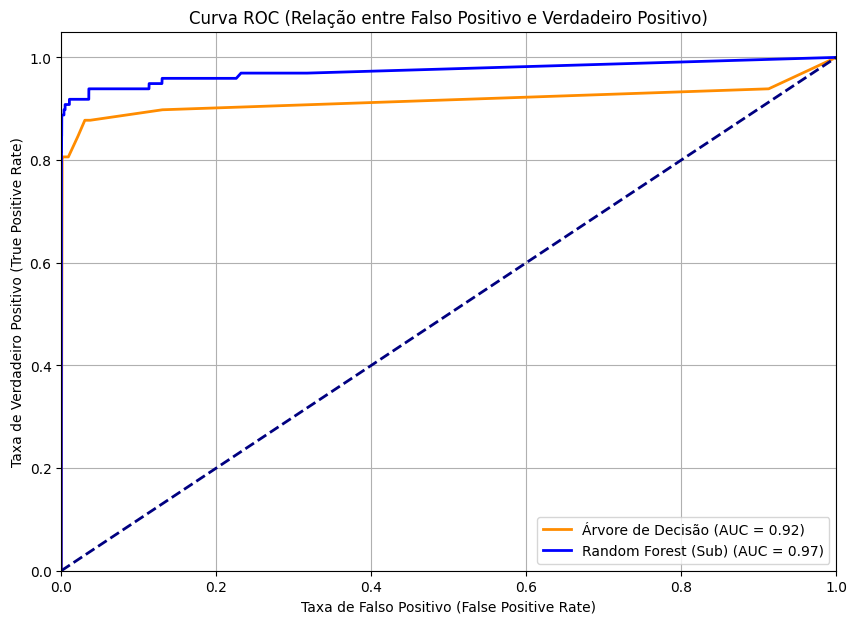

Neste gráfico da Curva ROC, o eixo horizontal (Eixo X) representa a Taxa de Falso Positivo.
Modelos com curvas mais próximas do canto inferior esquerdo geralmente têm uma Taxa de Falso Positivo menor para uma dada Taxa de Verdadeiro Positivo.


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Curva ROC

# Calcular a Curva ROC para a Árvore de Decisão
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt_plot = auc(fpr_dt, tpr_dt)

# Calcular a Curva ROC para o Random Forest treinado no subconjunto
fpr_rf_subset, tpr_rf_subset, thresholds_rf_subset = roc_curve(y_test_orig, y_pred_proba_rf_subset)
roc_auc_rf_subset_plot = auc(fpr_rf_subset, tpr_rf_subset)

plt.figure(figsize=(10, 7))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'Árvore de Decisão (AUC = {roc_auc_dt_plot:.2f})')
plt.plot(fpr_rf_subset, tpr_rf_subset, color='blue', lw=2, label=f'Random Forest (Sub) (AUC = {roc_auc_rf_subset_plot:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate)')
plt.title('Curva ROC (Relação entre Falso Positivo e Verdadeiro Positivo)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("Neste gráfico da Curva ROC, o eixo horizontal (Eixo X) representa a Taxa de Falso Positivo.")

print("Modelos com curvas mais próximas do canto inferior esquerdo geralmente têm uma Taxa de Falso Positivo menor para uma dada Taxa de Verdadeiro Positivo.")